In [83]:
%matplotlib inline
from __future__ import division
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import utils
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from time import time

In [2]:
visitors, events, devices, url_categories = utils.load_data(event_categories=True)
#categorized_events = utils.categorize_events(events, url_categories)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (5,6,7,8,11,12,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Use Cases
- ok
#### Pharma/Device Branded Research
- Visits a pharma or medical device site for a specific brand
#### Pharma/Device Unbranded Research
- Visits a pharma or medical device unbranded education site
#### Publication Research
- Visits a publication site
#### Professional Social Media / Career
- Visits a professional social media or recruitment site
#### Education / Tools
- Visits a site focused on educational resources and tools to better serve patients
#### Mixed Visits
- A combination of anything above; can flesh out specific combinations if they are frequent enough (ex: social + publication)

In [18]:
def define_use_case(event):
    if event.site_category == 'Publisher':
        return 'Publication Research'
    elif event.site_category in ['Reference Tool', 'Medical Education', 'Multi-Channel Marketing']:
        return 'Education/Tools'
    elif event.site_category in ['Pharma', 'Med Device']:
        if event.site_sub_category.strip() in ['Branded HCP', 'Branded Consumer']:
            return 'Branded Pharma'
        elif event.site_sub_category.strip() in ['Unbranded HCP', 'Unbranded Consumer']:
            return 'Unbranded Pharma'
    elif event.site_category in ['Professional Social', 'Medical Association', 'Recruiter']:
        return 'Professional/Social Media'
    else:
        return 'Other'

In [19]:
events['use_case'] = events.apply(lambda x: define_use_case(x), axis=1)

In [7]:
events.use_case.value_counts()

publication_research    1052303
education_tools          550969
branded                  136255
social_media              83496
other                     35462
unbranded                  4101
Name: use_case, dtype: int64

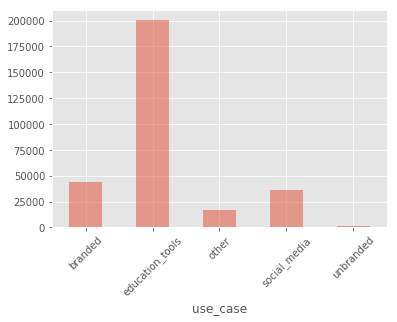

In [12]:
events[events.use_case<>'publication_research'].groupby('use_case').session_id.nunique().plot.bar(rot=45, alpha=0.5)

In [23]:
#sessions = events.groupby('session_id').event_id.count().reset_index()
sessions = sessions.rename(columns={'event_id':'page_views'})

In [24]:
event_sessions = events.drop_duplicates('session_id')

In [26]:
event_sessions = pd.merge(event_sessions, sessions, on='session_id')

In [29]:
event_sessions = pd.merge(visitors, event_sessions, on='dg_id')

In [31]:
event_sessions.columns

Index([u'visitor_id', u'dg_id', u'identity_type', u'professional_designation',
       u'npi_number', u'primary_specialty', u'primary_specialty_group',
       u'secondary_specialty', u'secondary_specialty_group', u'first_name',
       u'last_name', u'formatted_name', u'city', u'state', u'zipcode',
       u'birth_year', u'grad_year', u'grad_school', u'gender',
       u'suspected_bot', u'exclude', u'event_id', u'machine_fingerprint',
       u'ip_address_fingerprint', u'session_id', u'host', u'url', u'title',
       u'timestamp', u'js_page_cnt', u'referrer', u'scheme', u'path', u'query',
       u'fragment', u'reason', u'category_url', u'site_category',
       u'site_sub_category', u'disease_category', u'disease', u'pharma_firm',
       u'use_case', u'page_views'],
      dtype='object')

In [34]:
tableau_sessions = event_sessions[['timestamp', 'dg_id', 'npi_number', 'primary_specialty', 'site_category', 'site_sub_category', 'disease_category', 'disease', 'pharma_firm', 'use_case', 'page_views']]

In [38]:
tableau_sessions.to_csv('../data/use_case_sessions.csv')

In [230]:
tableau_sessions.head()

,timestamp,dg_id,npi_number,primary_specialty,site_category,site_sub_category,disease_category,disease,pharma_firm,use_case,page_views
0,2017-02-14 23:29:52.100,0000124213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,1
1,2017-02-04 12:44:07.660,R0000000026,NaN,NaN,Multi-Channel Marketing,Multi Topic,Multiple,NaN,NaN,Education/Tools,1
2,2017-03-17 13:20:51.610,R0000000098,NaN,NaN,Publisher,Multi Topic,Multiple,NaN,NaN,Publication Research,1
3,2017-04-09 12:11:33.693,R0000000358,NaN,NaN,Recruiter,Multi Topic,Multiple,NaN,NaN,Professional/Social Media,1
4,2017-05-03 15:40:07.033,R0000000651,NaN,NaN,Publisher,Multi Topic,Multiple,NaN,NaN,Publication Research,2


In [67]:
personas = session_use_cases.groupby('dg_id').use_case.apply(list).reset_index()
personas['total_sessions'] = personas.use_case.apply(lambda x: len(x))
personas['use_case_counts'] = personas.use_case.apply(lambda x: Counter(x))

In [68]:
single_use_case = personas[personas.use_case_counts.apply(lambda x: len(x))==1]
multi_use_case = personas[personas.use_case_counts.len > 1]

In [69]:
len(single_use_case)/len(personas)

0.7634587020648967

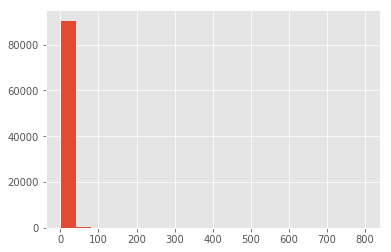

In [72]:
single_use_case.total_sessions.hist(bins=20)

In [75]:
len(personas[personas.total_sessions>1])/len(personas)

0.5591395146151783

In [81]:
len(single_use_case)/len(personas)

0.7634587020648967

In [82]:
len(single_use_case[single_use_case.total_sessions>1])/len(personas[personas.total_sessions>1])

0.5769547818527899

In [77]:
single_use_case[single_use_case.total_sessions>1].use_case_counts.apply(lambda x: x.items()[0][0]).value_counts()

publication_research    21098
education_tools         13503
social_media             1835
branded                  1540
other                     497
unbranded                  22
Name: use_case_counts, dtype: int64

In [195]:
personas['pharma'] = personas.use_case_counts.apply(lambda x: x['branded'] + x['unbranded'])

In [198]:
personas[personas.pharma>0]

,dg_id,use_case,total_sessions,use_case_counts,cluster,pharma
9,R0000002268,"[branded, education_tools]",2,"{u'education_tools': 1, u'branded': 1}",0,1
18,R0000006692,[branded],1,{u'branded': 1},0,1
25,R0000008040,"[branded, publication_research]",2,"{u'branded': 1, u'publication_research': 1}",0,1
28,R0000010415,"[social_media, social_media, branded]",3,"{u'branded': 1, u'social_media': 2}",0,1
30,R0000011735,[branded],1,{u'branded': 1},0,1
34,R0000013730,[branded],1,{u'branded': 1},0,1
41,R0000016806,[branded],1,{u'branded': 1},0,1
49,R0000021815,"[social_media, other, branded, social_media, p...",5,"{u'branded': 1, u'other': 1, u'social_media': ...",0,1
51,R0000023662,[branded],1,{u'branded': 1},0,1
52,R0000023733,"[social_media, branded, publication_research]",3,"{u'branded': 1, u'social_media': 1, u'publicat...",0,1


In [206]:
dg_phirms = event_sessions[event_sessions.site_category=='Pharma'].groupby('dg_id').pharma_firm.apply(list).reset_index()
dg_phirms['phirm_counts'] = dg_phirms.pharma_firm.apply(lambda x: Counter(x))

In [209]:
personas = pd.merge(personas, dg_phirms[['dg_id', 'phirm_counts']], on='dg_id', how='left')

In [231]:
personas['number_use_cases'] = personas.use_case_counts.apply(lambda x: len(x))

In [232]:
multi_use_case = personas

,dg_id,use_case,total_sessions,use_case_counts,cluster,pharma,phirm_counts,number_use_cases
0,0000124213,[other],1,{u'other': 1},0,0,NaN,1
1,R0000000026,[education_tools],1,{u'education_tools': 1},0,0,NaN,1
2,R0000000098,[publication_research],1,{u'publication_research': 1},0,0,NaN,1
3,R0000000358,[social_media],1,{u'social_media': 1},0,0,NaN,1
4,R0000000651,"[publication_research, publication_research, p...",20,{u'publication_research': 20},0,0,NaN,1
5,R0000000720,[education_tools],1,{u'education_tools': 1},0,0,NaN,1
6,R0000000823,[publication_research],1,{u'publication_research': 1},0,0,NaN,1
7,R0000000996,"[publication_research, publication_research, p...",17,{u'publication_research': 17},0,0,NaN,1
8,R0000002204,"[social_media, social_media, social_media]",3,{u'social_media': 3},0,0,NaN,1
9,R0000002268,"[branded, education_tools]",2,"{u'education_tools': 1, u'branded': 1}",0,1,{u'Merck': 1},2


In [236]:
vectorizer = CountVectorizer(min_df=1)
#X = vectorizer.fit_transform(personas.use_case.apply(lambda x: ', '.join(x)).as_matrix())
#Xm = vectorizer.fit_transform(single_use_case.use_case.apply(lambda x: ', '.join(x)).as_matrix())
Xt = vectorizer.fit_transform(personas[personas.number_use_cases>1].use_case.apply(lambda x: ', '.join(x)).as_matrix())
km = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1, verbose=1)

t0 = time()
km.fit(Xt)
print ("done in %0.3fs" % (time() - t0))
print()

personas['cluster'] = ''
personas.loc[personas.number_use_cases>1, 'cluster'] = km.labels_

Initialization complete
Iteration  0, inertia 47699153.000
Iteration  1, inertia 42518357.231
Iteration  2, inertia 41302064.471
Iteration  3, inertia 40868583.683
Iteration  4, inertia 40597130.958
Iteration  5, inertia 40372862.766
Iteration  6, inertia 40122120.298
Iteration  7, inertia 39912667.987
Iteration  8, inertia 39809269.237
Iteration  9, inertia 39799896.354
Iteration 10, inertia 39793998.495
Iteration 11, inertia 39792798.489
Iteration 12, inertia 39792718.444
Iteration 13, inertia 39792600.860
Iteration 14, inertia 39792415.977
Iteration 15, inertia 39792284.949
Iteration 16, inertia 39792056.935
Iteration 17, inertia 39791736.249
Converged at iteration 17: center shift 0.000000e+00 within tolerance 7.624384e-02
done in 0.927s



In [238]:
personas.cluster.value_counts()

     91102
0    27879
2      311
3       25
1       11
Name: cluster, dtype: int64

In [247]:
i = 0
while i < 10:
    print(personas[personas.cluster==0].sample().use_case_counts.item())
    i+=1

Counter({'publication_research': 5, 'other': 2, 'branded': 1, 'social_media': 1})
Counter({'education_tools': 4, 'publication_research': 1})
Counter({'social_media': 2, 'publication_research': 1})
Counter({'publication_research': 19, 'branded': 7, 'social_media': 5, 'other': 1})
Counter({'branded': 1, 'publication_research': 1})
Counter({'education_tools': 4, 'publication_research': 3})
Counter({'publication_research': 7, 'social_media': 5, 'education_tools': 2, 'branded': 1})
Counter({'publication_research': 3, 'branded': 2, 'other': 1})
Counter({'branded': 6, 'publication_research': 1})
Counter({'branded': 1, 'other': 1})


In [248]:
i = 0
while i < 10:
    print(personas[personas.cluster==1].sample().use_case_counts.item())
    i+=1

Counter({'publication_research': 1254, 'other': 21, 'education_tools': 4, 'branded': 4})
Counter({'publication_research': 4260, 'other': 61, 'education_tools': 35, 'branded': 25, 'social_media': 7})
Counter({'publication_research': 3937, 'other': 45, 'branded': 2, 'education_tools': 1})
Counter({'publication_research': 1495, 'other': 29, 'education_tools': 24, 'branded': 8, 'social_media': 4})
Counter({'publication_research': 2394, 'social_media': 113, 'other': 41, 'branded': 16, 'education_tools': 15})
Counter({'publication_research': 2394, 'social_media': 113, 'other': 41, 'branded': 16, 'education_tools': 15})
Counter({'publication_research': 1557, 'education_tools': 76, 'other': 27, 'social_media': 22, 'branded': 17, 'unbranded': 1})
Counter({'publication_research': 1499, 'education_tools': 66, 'social_media': 32, 'branded': 32, 'other': 24, 'unbranded': 4})
Counter({'publication_research': 4260, 'other': 61, 'education_tools': 35, 'branded': 25, 'social_media': 7})
Counter({'publi

In [250]:
i = 0
while i < 10:
    print(personas[personas.cluster==3].sample().use_case_counts.item())
    i+=1

Counter({'education_tools': 572, 'publication_research': 302, 'social_media': 21, 'branded': 15, 'other': 5, 'unbranded': 2})
Counter({'education_tools': 632, 'publication_research': 551, 'branded': 42, 'social_media': 17, 'other': 8, 'unbranded': 2})
Counter({'publication_research': 508, 'education_tools': 498, 'branded': 28, 'social_media': 11, 'other': 9})
Counter({'education_tools': 491, 'publication_research': 367, 'branded': 16, 'other': 5, 'social_media': 4, 'unbranded': 1})
Counter({'education_tools': 639, 'publication_research': 262, 'branded': 31, 'social_media': 11, 'other': 6, 'unbranded': 1})
Counter({'education_tools': 702, 'publication_research': 153, 'social_media': 8, 'branded': 8, 'unbranded': 6, 'other': 1})
Counter({'education_tools': 472, 'publication_research': 58, 'branded': 4, 'other': 3})
Counter({'education_tools': 1415, 'publication_research': 509, 'social_media': 30, 'branded': 26, 'unbranded': 9, 'other': 5})
Counter({'publication_research': 508, 'education

In [229]:
personas[~personas.use_case.apply(lambda x: 'publication_research' in x)]

,dg_id,use_case,total_sessions,use_case_counts,cluster,pharma,phirm_counts
0,0000124213,[other],1,{u'other': 1},0,0,NaN
1,R0000000026,[education_tools],1,{u'education_tools': 1},0,0,NaN
3,R0000000358,[social_media],1,{u'social_media': 1},0,0,NaN
5,R0000000720,[education_tools],1,{u'education_tools': 1},0,0,NaN
8,R0000002204,"[social_media, social_media, social_media]",3,{u'social_media': 3},0,0,NaN
9,R0000002268,"[branded, education_tools]",2,"{u'education_tools': 1, u'branded': 1}",0,1,{u'Merck': 1}
10,R0000002822,"[social_media, social_media]",2,{u'social_media': 2},0,0,NaN
18,R0000006692,[branded],1,{u'branded': 1},0,1,{u'Genentech/Astellas': 1}
22,R0000007626,[social_media],1,{u'social_media': 1},0,0,NaN
23,R0000007628,[social_media],1,{u'social_media': 1},0,0,NaN


In [223]:
personas[personas.cluster==2]

,dg_id,use_case,total_sessions,use_case_counts,cluster,pharma,phirm_counts
261,R0000130434,"[publication_research, publication_research, p...",343,{u'publication_research': 343},2,0,NaN
340,R0000166804,"[education_tools, social_media, publication_re...",202,"{u'education_tools': 54, u'social_media': 6, u...",2,0,NaN
497,R0000245082,"[publication_research, publication_research, p...",162,"{u'education_tools': 1, u'unbranded': 1, u'pub...",2,1,{u'Merck': 1}
531,R0000264029,"[education_tools, publication_research, public...",560,"{u'education_tools': 49, u'branded': 9, u'soci...",2,9,"{u'Celgene': 1, u'Merck': 2, u'Genentech': 5}"
558,R0000277846,"[publication_research, publication_research, p...",297,{u'publication_research': 297},2,0,NaN
625,R0000312899,"[publication_research, publication_research, p...",180,"{u'branded': 2, u'social_media': 10, u'publica...",2,2,{u'Merck': 2}
656,R0000326562,"[social_media, publication_research, publicati...",572,"{u'education_tools': 2, u'branded': 15, u'soci...",2,15,"{u'Merck': 14, u'Genentech/Biogen': 1}"
667,R0000333822,"[publication_research, publication_research, p...",495,{u'publication_research': 495},2,0,NaN
680,R0000342068,"[publication_research, publication_research, p...",217,{u'publication_research': 217},2,0,NaN
839,R0000434016,"[publication_research, publication_research, p...",275,{u'publication_research': 275},2,0,NaN


In [219]:
personas.loc[56985].use_case_counts

Counter({'branded': 25,
         'education_tools': 35,
         'other': 61,
         'publication_research': 4260,
         'social_media': 7})

In [222]:
personas.loc[115621].use_case_counts

Counter({'branded': 67,
         'education_tools': 10,
         'other': 9,
         'publication_research': 236,
         'social_media': 24,
         'unbranded': 7})

In [221]:
personas[personas.pharma>10]

,dg_id,use_case,total_sessions,use_case_counts,cluster,pharma,phirm_counts
106,R0000052561,"[branded, branded, branded, branded, branded, ...",27,{u'branded': 27},0,27,{u'Merck': 27}
155,R0000077051,"[publication_research, publication_research, p...",41,"{u'education_tools': 1, u'branded': 12, u'soci...",0,13,"{u'Celgene': 3, u'Eisai': 1, u'Merck': 7, u'As..."
352,R0000170835,"[branded, branded, branded, branded, branded, ...",57,{u'branded': 57},0,57,{u'Celgene': 57}
354,R0000170950,"[branded, branded, branded, branded, branded, ...",20,{u'branded': 20},0,20,{u'Merck': 20}
415,R0000206372,"[branded, branded, branded, branded, branded, ...",23,{u'branded': 23},0,23,{u'Merck': 23}
456,R0000228919,"[branded, branded, branded, branded, branded, ...",13,{u'branded': 13},0,13,"{u'Merck': 12, u'Astellas/Medivation': 1}"
638,R0000320576,"[publication_research, branded, branded, brand...",13,"{u'branded': 12, u'publication_research': 1}",0,12,{u'Merck': 12}
656,R0000326562,"[social_media, publication_research, publicati...",572,"{u'education_tools': 2, u'branded': 15, u'soci...",2,15,"{u'Merck': 14, u'Genentech/Biogen': 1}"
897,R0000459804,"[publication_research, publication_research, e...",946,"{u'publication_research': 707, u'other': 9, u'...",2,11,"{u'Celgene': 2, u'Eisai': 2, u'Merck': 6}"
1394,R0000731317,"[branded, branded, branded, branded, branded, ...",39,{u'branded': 39},0,39,{u'Merck': 39}


In [154]:
single_use_case.groupby('cluster').total_sessions.agg(['mean', 'count'])

,mean,count
cluster,,
0,217.550000,20
1,2.501159,42709
2,124.626506,166
3,299.934783,46
4,34.318854,1082
5,2.126405,47079


In [146]:
personas.use_case_counts.apply(lambda x: x['branded']).sort_values(ascending=False)

2358      355
71867     300
25185     248
40997     212
99007     151
50927     146
79766     118
28520     111
26775     105
79063      98
107564     85
98925      80
105405     76
97486      71
66736      67
115621     67
15503      65
90430      65
93109      65
100868     61
64635      60
62502      60
36224      60
78846      60
78175      60
8866       59
352        57
71145      56
92262      54
1751       54
         ... 
77139       0
77140       0
77116       0
77114       0
77088       0
77113       0
77089       0
77090       0
77091       0
77092       0
77093       0
77094       0
77095       0
77096       0
77097       0
77098       0
77099       0
77100       0
77101       0
77102       0
77103       0
77104       0
77105       0
77106       0
77107       0
77109       0
77110       0
77111       0
77112       0
0           0
Name: use_case_counts, Length: 119328, dtype: int64

In [130]:
c = Counter({'branded': 16,
         'education_tools': 15,
         'other': 41,
         'publication_research': 2394,
         'social_media': 113})

In [136]:
pd.DataFrame(personas.use_case_counts)

,use_case_counts
0,{u'other': 1}
1,{u'education_tools': 1}
2,{u'publication_research': 1}
3,{u'social_media': 1}
4,{u'publication_research': 20}
5,{u'education_tools': 1}
6,{u'publication_research': 1}
7,{u'publication_research': 17}
8,{u'social_media': 3}
9,"{u'education_tools': 1, u'branded': 1}"


In [135]:
personas.groupby('cluster').use_case_counts.apply(lambda x: x['education_tools'])

KeyError: 'education_tools'

In [106]:
personas.loc[56985]['use_case_counts']

Counter({'branded': 25,
         'education_tools': 35,
         'other': 61,
         'publication_research': 4260,
         'social_media': 7})

In [97]:
personas.loc[78997]['use_case_counts']

Counter({'branded': 2,
         'education_tools': 1,
         'other': 45,
         'publication_research': 3937})

In [92]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X.toarray())

In [94]:
import random
random.sample(range(pca.shape[0]), 1)

[36895]

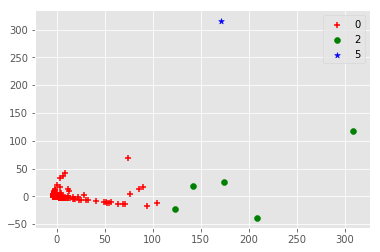

In [95]:
import matplotlib.pyplot as plt
for i in random.sample(range(pca.shape[0]), 1000):
    if km.labels_[i] == 0:
        c1 = plt.scatter(pca[i,0],pca[i,1],c='r', marker='+')
    elif km.labels_[i] == 2:
        c2 = plt.scatter(pca[i,0],pca[i,1],c='g', marker='o')
    elif km.labels_[i] == 5:
        c3 = plt.scatter(pca[i,0],pca[i,1],c='b',marker='*') 
plt.legend([c1, c2, c3], ['0', '2', '5'])
plt.figure(figsize=(20,10))
plt.show()

In [ ]:
i